##  A library for data loaders.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import copy
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Dict
from torch.utils.data import IterableDataset
import warnings


import datatable as dt
import numpy as np
import pandas as pd
import torch
import torch_geometric.transforms as T
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid, WebKB, WikipediaNetwork
from torch_geometric.nn import GAE, VGAE, GCNConv
from torch_geometric.seed import seed_everything as th_seed
from typing import Any, Dict, List, Tuple



from utils.utils import set_dirs, update_config_with_model_dims
from utils.model import NESS

In [2]:
#In this cell there some class and function for loading dataset and preprocessing

class GraphLoader:
    """
    Data loader class for graph data.
    """

    def __init__(self, config: Dict[str, Any], dataset_name: str, kwargs: Dict[str, Any] = {}) -> None:
        """
        Initializes the GraphLoader.

        Parameters
        ----------
        config : Dict[str, Any]
            Dictionary containing options and arguments.
        dataset_name : str
            Name of the dataset to load.
        kwargs : Dict[str, Any], optional
            Dictionary for additional parameters if needed, by default {}.
        """
        # Get config
        self.config = config
        # Set the seed
        th_seed(config["seed"])
        # Set the paths
        paths = config["paths"]
        # data > dataset_name
        file_path = os.path.join(paths["data"], dataset_name)
        # Get the datasets
        self.train_data, self.validation_data, self.test_data = self.get_dataset(dataset_name, file_path)        
        

    def get_dataset(self, dataset_name: str, file_path: str) -> Tuple[Data, Data, Data]:
        """
        Returns the training, validation, and test datasets.

        Parameters
        ----------
        dataset_name : str
            Name of the dataset to load.
        file_path : str
            Path to the dataset.

        Returns
        -------
        Tuple[Data, Data, Data]
            Training, validation, and test datasets.
        """

        # Initialize Graph dataset class
        graph_dataset = GraphDataset(self.config, datadir=file_path, dataset_name=dataset_name)
        
        # Load Training, Validation, Test datasets
        train_data, val_data, test_data = graph_dataset._load_data()
        
        # Generate static subgraphs from training set
        train_data = self.generate_subgraphs(train_data)
  
        # Return
        return train_data, val_data, test_data
    
    
    def generate_subgraphs(self, train_data: Data) -> List[Data]:
        """
        Generates subgraphs from the training data.

        Parameters
        ----------
        train_data : Data
            Training data containing the graph.

        Returns
        -------
        List[Data]
            List of subgraphs generated from the training data.
        """
        # Initialize list to hold subgraphs
        subgraphs = [train_data]

        # Check if we are generating subgraphs from the graph. If False, we are in standard GAE mode
        if self.config["n_subgraphs"] > 1:
                
            # Generate subgraphs
            for i in range(self.config["n_subgraphs"]):
                
                # Change random seed
                th_seed(i)
                
                partition = 1.0/(self.config["n_subgraphs"]-i)
                
                # For the last subgraph, get 95% of the remaining graph. if num_val=1.0, RandomLinkSplit will raise error
                if partition == 1.0:
                    partition = 0.95
                    
                random_link_split = T.RandomLinkSplit(num_val=partition, 
                                                      num_test=0, 
                                                      is_undirected=True, 
                                                      split_labels=True, 
                                                      add_negative_train_samples=False)

                # get a subgraph from training data
                train_data, train_subgraph, _ = random_link_split(train_data)
                
                # Make sure that we are using only the nodes within the subgraph by overwriting the edge index 
                # with positive edge index + positive edge index reversed in direction (to make it undirected)
                pos_swapped = train_subgraph.pos_edge_label_index[[1,0],:] 
                train_subgraph.edge_index = torch.cat((train_subgraph.pos_edge_label_index, pos_swapped), dim=1)
                
                # Remove negative edge attributes. We want to sample negative samples during training
                # Masks are also not needed
                if hasattr(train_subgraph, "neg_edge_label_index"):
                    delattr(train_subgraph, "neg_edge_label_index")
                    delattr(train_subgraph, "neg_edge_label")
                    
                if hasattr(train_subgraph, "train_mask"):
                    delattr(train_subgraph, "train_mask")
                    delattr(train_subgraph, "val_mask")
                    delattr(train_subgraph, "test_mask")


                # store the sampled subgraph
                subgraphs = [train_subgraph] + subgraphs
                       
        # Change random seed back to original
        th_seed(self.config["seed"])
        
        # Return all subgraphs and original larger graph
        return subgraphs

    
def get_transform(options):
    """Splits data to train, validation and test, and moves them to the device"""
    transform = T.Compose([
        T.NormalizeFeatures(),
        T.ToDevice(options["device"]),
        T.RandomLinkSplit(num_val=0.05, 
                          num_test=0.15, 
                          is_undirected=True,
                          split_labels=True, 
                          add_negative_train_samples=False),
        ])
        
    return transform


class GraphDataset:
    """
    Dataset class for graph data format.
    """

    def __init__(self, config: Dict[str, Any], datadir: str, dataset_name: str) -> None:
        """
        Initializes the GraphDataset.

        Parameters
        ----------
        config : Dict[str, Any]
            Dictionary containing options and arguments.
        datadir : str
            The path to the data directory.
        dataset_name : str
            Name of the dataset to load.
        """
        self.config = config
        self.paths = config["paths"]
        self.dataset_name = dataset_name
        self.data_path = os.path.join(self.paths["data"], 'Planetoid')
        self.transform = get_transform(config)

        
    def _load_data(self) -> Tuple[Data, Data, Data]:
        """
        Loads one of many available datasets and returns features and labels.

        Returns
        -------
        Tuple[Data, Data, Data]
            Training, validation, and test datasets.
        """
        if self.dataset_name.lower() in ['cora', 'citeseer', 'pubmed']:
            # Get the dataset
            dataset = Planetoid(self.data_path, self.dataset_name, split="random", transform = self.transform)
        elif  self.dataset_name.lower() in ['chameleon']:
            # Get the dataset
            dataset = WikipediaNetwork(root=self.data_path, name=self.dataset_name, transform = self.transform)
        elif  self.dataset_name.lower() in ["cornell", "texas", "wisconsin"]:
            # Get the dataset
            dataset = WebKB(root=self.data_path, name=self.dataset_name, transform = self.transform) 
        else:
            print(f"Given dataset name is not found. Check for typos, or missing condition ")
            exit()
            
        # Data splits
        train_data, val_data, test_data = dataset[0]
        
        # Return
        return train_data, val_data, test_data


In [3]:

#Loads arguments and configuration for GNN-based encoder used in NESS.


import os
import pprint
from argparse import ArgumentParser
from os.path import abspath, dirname

import torch

from utils.utils import get_runtime_and_model_config, print_config


def get_arguments():
    # Initialize parser
    parser = ArgumentParser()
    # Dataset can be provided via command line
    parser.add_argument("-d", "--dataset", type=str, default="cora")
    # Encoder type
    parser.add_argument("-gnn", "--gnn", type=str, default="GNAE")
    # Random seed
    parser.add_argument("-seed", "--seed", type=int, default=57)
    # Whether to use contrastive loss
    parser.add_argument("-cl", "--cl", type=bool, default=False)
    # Whether to add noise to input
    parser.add_argument("-an", "--an", type=bool, default=True)
    # Whether to use GPU.
    parser.add_argument("-g", "--gpu", dest='gpu', action='store_true', 
                        help='Used to assign GPU as the device, assuming that GPU is available')
    
    parser.add_argument("-ng", "--no_gpu", dest='gpu', action='store_false', 
                        help='Used to assign CPU as the device')
    parser.set_defaults(gpu=True)
    
    # GPU device number as in "cuda:0". Defaul is 0.
    parser.add_argument("-dn", "--device_number", type=str, default='0', 
                        help='Defines which GPU to use. It is 0 by default')
    
    # Experiment number
    parser.add_argument("-ex", "--experiment", type=int, default=1)
    # Load model saved at specific epoch
    parser.add_argument("-m", "--model_at_epoch", type=int, default=None)
    
    # Return parser arguments along with the unknown ones
    args, unknown = parser.parse_known_args()
    return args


def get_config(args):
    # Load runtime config from config folder: ./config/
    config = get_runtime_and_model_config(args)
    # Define which device to use: GPU or CPU
    config["device"] = torch.device('cuda:'+args.device_number if torch.cuda.is_available() and args.gpu else 'cpu')
    # Model at specific epoch
    config["model_at_epoch"] = args.model_at_epoch
    # Indicate which device is being used
    print(f"Device being used is {config['device']}")
    # Return
    return config

def print_config_summary(config, args=None):
    """Prints out summary of options and arguments used"""
    # Summarize config on the screen as a sanity check
    print(100 * "=")
    print(f"Here is the configuration being used:\n")
    print_config(config)
    print(100 * "=")
    if args is not None:
        print(f"Arguments being used:\n")
        print_config(args)
        print(100 * "=")


In [4]:
# Get parser / command line arguments
args = get_arguments()
# Get configuration file
config = get_config(args)


# By default, we are using the name of the dataset. This can be customized.
config["experiment"] = config["dataset"]

# File name to use when saving results as csv. This can be customized
config["file_name"] = config["experiment"] + "_sub" + str(config["n_subgraphs"]) + '_seed' + str(config["seed"])

Device being used is cpu


In [5]:
# Summarize config and arguments on the screen as a sanity check
print_config_summary(config, args)


Here is the configuration being used:

+-------------------+----------------------------------------------+
|     Parameter     |                    Value                     |
+===================+==============================================+
| Add noise         | True                                         |
+-------------------+----------------------------------------------+
| Aggregation       | mean                                         |
+-------------------+----------------------------------------------+
| Batch size        | 128                                          |
+-------------------+----------------------------------------------+
| Contrastive loss  | False                                        |
+-------------------+----------------------------------------------+
| Cosine similarity | False                                        |
+-------------------+----------------------------------------------+
| Dataset           | cora                                      

In [6]:
# We need these two function for training dataset

def train(config: Dict, data_loader: IterableDataset, save_weights: bool = True) -> None:
    """
    Trains the model using provided configuration and data loader.

    Parameters
    ----------
    config : dict
        Dictionary containing options.

    data_loader : IterableDataset
        Pytorch data loader used for training the model.

    save_weights : bool, optional
        If True, the trained model is saved. By default, it's True.
    """
    # Instantiate model
    model = NESS(config)
    # Start the clock to measure the training time
    start = time.process_time()
    # Fit the model to the data
    model.fit(data_loader)
    # Total time spent on training
    training_time = time.process_time() - start
    # Report the training time
    print("Done with training...")
    print(f"Training time:  {training_time//60} minutes, {training_time%60} seconds")
    # Return the best Test set AUC
    return model.test_auc, model.test_ap, model.t_inference


def main(config: Dict) -> None:
    """
    The main function that starts the execution of the program. Takes the 
    configuration dictionary as input.

    Parameters
    ----------
    config : dict
        Dictionary containing options.
    """
    # Ser directories (or create if they don't exist)
    set_dirs(config)
    # Get data loader for first dataset.
    ds_loader = GraphLoader(config, dataset_name=config["dataset"])
    # Add the number of features in a dataset as the first dimension of the model
    config = update_config_with_model_dims(ds_loader, config)
    # Start training and save model weights at the end
    test_auc, test_ap,t_inference = train(config, ds_loader, save_weights=True)
    # Return best test auc
    return test_auc, test_ap, t_inference

In [7]:
# Run the main

test_auc, test_ap, t_inference = main(config)

print(f"Test AUC: {test_auc}, AP: {test_ap}, Time inference:{t_inference}")

Directories are set.
Directories are set.
Building the models for training and evaluation in NESS framework...
----------------------------------------Summary of the models:----------------------------------------
================================== NESS Architecture ==================================
GAEWrapper(
  (gae): GAE(
    (encoder): GNAEEncoder(
      (linear1): Linear(in_features=1433, out_features=32, bias=True)
      (propagate): APPNP(K=1, alpha=0)
    )
    (decoder): InnerProductDecoder()
  )
)

Epoch:[-1], Total loss:7.8579, X recon loss:3.1438, val auc:NA
Done with saving models.
Done with saving models.
Done with saving models.
Epoch:[39] training loss:2.3542, X recon loss:0.9532, val auc:0.8980034408477786
Done with saving models.
Done with saving models.
Done with saving models.
Done with saving models.
Epoch:[79] training loss:2.2049, X recon loss:0.8895, val auc:0.917390738625685
Done with saving models.
Done with saving models.
Done with saving models.
Epoch:[119]

<Figure size 432x288 with 0 Axes>

In [9]:
#Plot utilities. Used to plot losses recorded during training.

import matplotlib.pyplot as plt
from typing import Dict, List


def save_loss_plot(losses: Dict[str, List[float]], plots_path: str) -> None:
    """
    Saves loss plot. 

    If validation loss is present, the plot includes both training and validation loss; otherwise, it includes only
    the training loss.

    Parameters
    ----------
    losses : dict
        A dictionary contains lists of losses. The keys are "tloss_e" for training loss and "vloss_e" for validation 
        loss. The values are lists of recorded loss values.
    plots_path : str
        Path to save the loss plot.
    """
    x_axis = list(range(len(losses["tloss_e"])))
    plt.plot(x_axis, losses["tloss_e"], c='r', label="Training")
    title = "Training"
    if len(losses["vloss_e"]) >= 1:
        # If validation loss is recorded less often, we need to adjust x-axis values by the factor of difference
        beta = len(losses["tloss_e"]) / len(losses["vloss_e"])
        x_axis = list(range(len(losses["vloss_e"])))
        # Adjust the values of x-axis by beta factor
        x_axis = [beta * i for i in x_axis]
        plt.plot(x_axis, losses["vloss_e"], c='b', label="Validation")
        title += " and Validation "
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title(title + " Loss", fontsize=12)
    plt.tight_layout()
    #plt.savefig(plots_path + "/loss.png")
    #plt.clf()
    plt.show()
    

def save_auc_plot(summary: Dict[str, List[float]], plots_path: str) -> None:
    """
    Saves AUC (Area Under the ROC Curve) plot during training.

    Parameters
    ----------
    summary : dict
        A dictionary contains list of loss and AUC values stored during training. The key for AUC values is 
        "val_auc".
    plots_path : str
        Path to save the AUC plot.
    """
    if len(summary["val_auc"]) > 1:
        
        x_axis = list(range(len(summary["val_auc"])))
        plt.plot(x_axis, summary["val_auc"], c='r', label="Validation")
            
        title = "AUCs during training"
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.legend(loc="upper right")
        plt.title(title, fontsize=12)
        plt.tight_layout()
        plt.savefig(plots_path + "/val_auc.png")
        plt.clf()

In [10]:
Dir='results/cora/training/loss/'

In [11]:
losses = pd.read_csv( Dir+'losses.csv', sep=',', header=0)

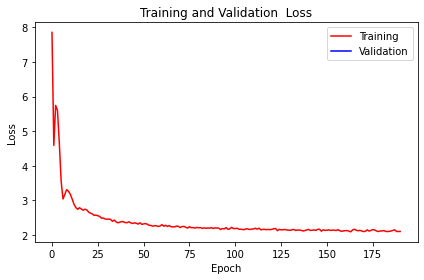

In [12]:
save_loss_plot(losses, Dir)

In [ ]:
GAEWrapper

##  Measurement of avarage of auc, and time inference 

In [8]:
import time
import statistics as stat


Eva_final=dict()


Base_model_Auc=[]
T_base_model=[]

In [12]:
for i in range(10):
    
    
        for epoch in range(60):
        train()
        train_acc, test_acc = test()
        print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')
        test_auc, test_ap, t_inference = main(config)

        print(f"Test AUC: {test_auc}, AP: {test_ap}, Time inference:{t_inference}")
       

        Base_model_Auc.append(test_auc)
        T_base_model.append(t_inference)

     

Directories are set.
Directories are set.
Building the models for training and evaluation in NESS framework...
----------------------------------------Summary of the models:----------------------------------------
================================== NESS Architecture ==================================
GAEWrapper(
  (gae): GAE(
    (encoder): GNAEEncoder(
      (linear1): Linear(in_features=1433, out_features=32, bias=True)
      (propagate): APPNP(K=1, alpha=0)
    )
    (decoder): InnerProductDecoder()
  )
)

Epoch:[-1], Total loss:7.8579, X recon loss:3.1438, val auc:NA
Done with saving models.
Done with saving models.
Done with saving models.
Epoch:[39] training loss:2.3542, X recon loss:0.9532, val auc:0.8980034408477786
Done with saving models.
Done with saving models.
Done with saving models.
Done with saving models.
Epoch:[79] training loss:2.2049, X recon loss:0.8895, val auc:0.917390738625685
Done with saving models.
Done with saving models.
Done with saving models.
Epoch:[119]

----------------------------------------Summary of the models:----------------------------------------
================================== NESS Architecture ==================================
GAEWrapper(
  (gae): GAE(
    (encoder): GNAEEncoder(
      (linear1): Linear(in_features=1433, out_features=32, bias=True)
      (propagate): APPNP(K=1, alpha=0)
    )
    (decoder): InnerProductDecoder()
  )
)

Epoch:[-1], Total loss:7.8579, X recon loss:3.1438, val auc:NA
Done with saving models.
Done with saving models.
Done with saving models.
Epoch:[39] training loss:2.3542, X recon loss:0.9532, val auc:0.8980034408477786
Done with saving models.
Done with saving models.
Done with saving models.
Done with saving models.
Epoch:[79] training loss:2.2049, X recon loss:0.8895, val auc:0.917390738625685
Done with saving models.
Done with saving models.
Done with saving models.
Epoch:[119] training loss:2.1607, X recon loss:0.8773, val auc:0.9202099206291836
Done with saving models.
Epoch:[159] tra

<Figure size 432x288 with 0 Axes>

In [13]:
Base_model_Auc

[0.9400029727608797,
 0.9400037718901485,
 0.9400029727608797,
 0.9400029727608797,
 0.9400029727608797,
 0.9400029727608797,
 0.9400045710194173,
 0.9400029727608797,
 0.9400037718901485,
 0.9400045710194173]

In [14]:
T_base_model

[0.05338859558105469,
 0.06249117851257324,
 0.06904840469360352,
 0.06248283386230469,
 0.06249856948852539,
 0.053392887115478516,
 0.05339694023132324,
 0.046889305114746094,
 0.05341219902038574,
 0.05340003967285156]

In [15]:
print(f'Base_model_Auc in ten time:')
print ("{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<15}|{:<20}"\
    .format(Base_model_Auc[0],Base_model_Auc[1],Base_model_Auc[2],\
        Base_model_Auc[3],Base_model_Auc[4],Base_model_Auc[5],\
        Base_model_Auc[6],Base_model_Auc[7],Base_model_Auc[8],Base_model_Auc[9]))
print ("-"*110)
print(f'Time Inference model in ten time:')
#print(T_base_model)
print ("{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<15}|{:<20}"\
    .format(T_base_model[0],T_base_model[1],T_base_model[2],\
        T_base_model[3],T_base_model[4],T_base_model[5],\
        T_base_model[6],T_base_model[7],T_base_model[8],T_base_model[9]))

Base_model_Auc in ten time:
0.9400029727608797|0.9400037718901485|0.9400029727608797|0.9400029727608797|0.9400029727608797|0.9400029727608797|0.9400045710194173|0.9400029727608797|0.9400037718901485|0.9400045710194173  
--------------------------------------------------------------------------------------------------------------
Time Inference model in ten time:
0.05338859558105469|0.06249117851257324|0.06904840469360352|0.06248283386230469|0.06249856948852539|0.053392887115478516|0.05339694023132324|0.046889305114746094|0.05341219902038574|0.05340003967285156 


In [16]:
import statistics as stat

base_model_accuracy_mean = stat.mean(Base_model_Auc)
base_model_accuracy_std =  stat.stdev(Base_model_Auc)
desc_auc = "{:.3f} ± {:.3f}".format(base_model_accuracy_mean,base_model_accuracy_std)
print(f"Auc: {desc_auc}"  )

Eva_final.update({'base model accuracy':float(format(base_model_accuracy_mean, '.4f'))})
                 
t_base_model_mean =stat.mean(T_base_model)
t_base_model_std =stat.stdev(T_base_model)   
desc_T = "{:.3f} ± {:.3f}".format(t_base_model_mean,t_base_model_std)

print(f"Time inference :{desc_T}")
Eva_final.update({'time inference of base model':float(format(t_base_model_mean, '.6f'))})

Auc: 0.940 ± 0.000
Time inference :0.057 ± 0.007
